# inD (LevelX)

## About

The inD dataset was created and published by a team from the Institute for Automotive Engineering (ika) of RWTH Aachen University to promote research in many different domains of mobility. The dataset can therefore be downloaded and used free of charge for academic and research purposes.

This dataset contains more than 11,500 road users including vehicles, bicyclists and pedestrians at intersections in Germany. The dataset consists of 10 hours of measurement data from four intersections.

### How to Apply Dataset

The inD dataset is free for non-commercial use only. According to the license and protocols, as a third-party, we cannot share any form of this dataset online. Please visit [the official website](https://levelxdata.com/ind-dataset/) of inD, fill in the application form and send your request.

### How to Obtain Map

The maps of inD dataset are manually created by Tactics2D, in the format of OpenStreetMap (OSM), labeled in Lanelet2 style. The maps are stored in `data/inD_map`. You can download them from [here](https://github.com/WoodOxen/tactics2d/tree/master/tactics2d/data/inD_map)

### Citation

```latex
@inproceedings{inD,
    title={The inD Dataset: A Drone Dataset of Naturalistic Road User Trajectories at German Intersections},
    author={Bock, Julian and Krajewski, Robert and Moers, Tobias and Runde, Steffen and Vater, Lennart and Eckstein, Lutz},
    booktitle={2020 IEEE Intelligent Vehicles Symposium (IV)},
    pages={1929-1934},
    year={2020},
    doi={10.1109/IV47402.2020.9304839}
}
```

## Data Analysis

> This part is independently conducted by Tactics2D.

According to meta records:

- Trajectory data files 00-06 are recorded in location 4 (denoted as inD_4)
- Trajectory data files 07-17 are recorded in location 1 (denoted as inD_1)
- Trajectory data files 18-29 are recorded in location 2 (denoted as inD_2)
- Trajectory data files 30-32 are recorded in location 3 (denoted as inD_3)

In [1]:
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import polars as pl
import numpy as np
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Setting up parameters for matplotlib
mpl.rcParams.update(
    {
        "figure.dpi": 200,  # 200 for high quality
        "font.family": "DejaVu Sans Mono",
        "font.size": 6,
        "font.stretch": "semi-expanded",
        "animation.html": "jshtml",
        "animation.embed_limit": 5000,
        "axes.edgecolor": "black",
        "axes.linewidth": 0.8,
        "axes.grid": True,
        "grid.color": "#cccccc",
        "axes.facecolor": "white",
    }
)
sns.set_palette("Set2")

In [3]:
locations = dict()
dfs_meta = pd.DataFrame()
for i in range(32):
    df_meta = pd.read_csv("../../data/inD/data/%02d_recordingMeta.csv" % i)
    locations[i] = df_meta["locationId"][0]
    dfs_meta = pd.concat([dfs_meta, df_meta], ignore_index=True)

In [4]:
dfs_track_meta = pd.DataFrame()
for i in range(32):
    df_track_meta = pd.read_csv("../../data/inD/data/%02d_tracksMeta.csv" % i)
    df_track_meta["locationId"] = locations[i]
    df_track_meta["fileId"] = i
    dfs_track_meta = pd.concat([dfs_track_meta, df_track_meta], ignore_index=True)

In [5]:
dfs = [pl.DataFrame()] * 4

for i in range(32):
    df = pl.read_csv("../../data/inD/data/%02d_tracks.csv" % i)
    df = df.select(["trackId", "frame", "xCenter", "yCenter", "heading", "xVelocity", "yVelocity"])
    df = df.with_columns(pl.lit(i).alias("fileId"))
    df = df.join(
        pl.DataFrame(dfs_track_meta)[["fileId", "trackId", "class"]],
        on=["fileId", "trackId"],
        how="left",
    )

    dfs[locations[i] - 1] = pl.concat([dfs[locations[i] - 1], df])

### Distribution of Trajectory on Map

We first attempt to align the trajectories with the map image. Fortunately, most traffic participants in this dataset exhibit rule-abiding behavior.

![Trajectories on maps](https://raw.githubusercontent.com/MotacillaAlba/image-storage/main/img/inD.png)

### Distribution of Trajectory Categories

There are two types of vehicles in the inD dataset: `car` and `truck_bus`. The composition of vehicle types varies considerably across different locations. Within each location, the proportion of each vehicle type remains relatively consistent across different trajectory files.

Notably, Location 2 features a high proportion of pedestrians and cyclists, **making it especially valuable for studying non-motorized traffic participants**.

In [6]:
dfs_meta["vehicle_ratio"] = dfs_meta["numVehicles"] / dfs_meta["numTracks"]
dfs_meta["locationId"] = pd.Categorical(
    dfs_meta["locationId"], categories=[1, 2, 3, 4], ordered=True
)

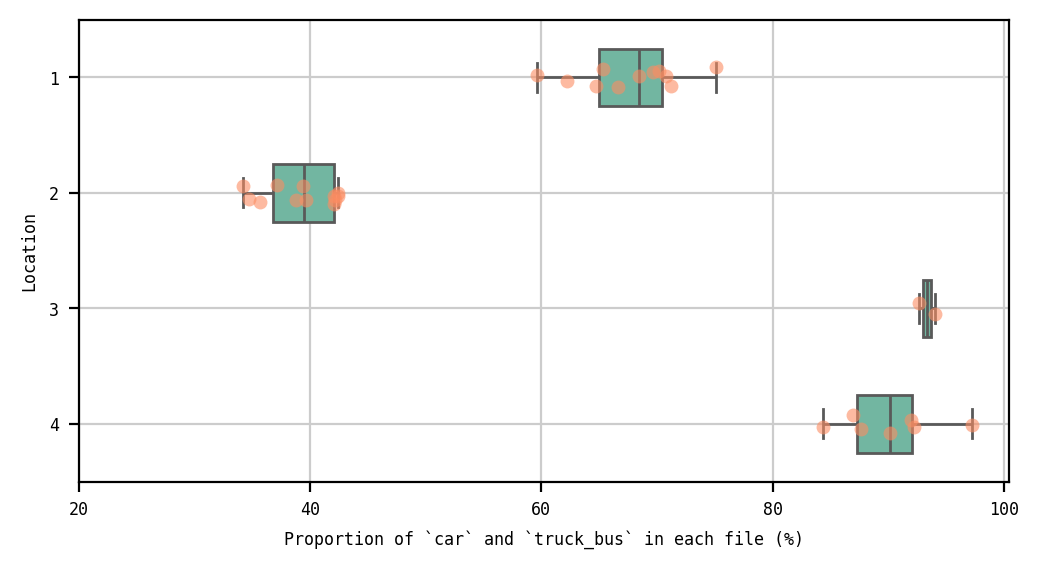

In [7]:
f, ax = plt.subplots(figsize=(6, 3))

sns.boxplot(data=dfs_meta, x="vehicle_ratio", y="locationId", width=0.5, ax=ax)

sns.stripplot(data=dfs_meta, x="vehicle_ratio", y="locationId", alpha=0.6, ax=ax)

ax.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticklabels(["20", "40", "60", "80", "100"])
ax.yaxis.grid(True)
ax.set_xlabel("Proportion of `car` and `truck_bus` in each file (%)")
ax.set_ylabel("Location")
plt.show()

### Distribution of Average Speed on Map

We present a heatmap of average vehicle speed across spatial grids at each location. The tight clustering of data points indicates that the trajectories have already been well-calibrated, with minimal variation across different data files.

Speed varies significantly across different regions on the map. Vehicles tend to maintain an average speed of around 15 m/s on straight road segments, while speeds drop sharply to about 5 m/s in turning areas. In pedestrian zones, the average speed within each grid is even lower, which aligns with expectations based on traffic behavior and road usage.

In [8]:
for i in range(4):
    x_min = np.floor(dfs[i]["xCenter"].min())
    x_max = np.ceil(dfs[i]["xCenter"].max())
    y_min = np.floor((-dfs[i]["yCenter"]).min())
    y_max = np.ceil((-dfs[i]["yCenter"]).max())
    vx = dfs[i]["xVelocity"].to_numpy()
    vy = dfs[i]["yVelocity"].to_numpy()

    x_edges = np.linspace(x_min, x_max, num=int((x_max - x_min) * 10 + 1), endpoint=True)
    y_edges = np.linspace(y_min, y_max, num=int((y_max - y_min) * 10 + 1), endpoint=True)
    x_bin = np.digitize(dfs[i]["xCenter"].to_numpy(), x_edges) - 1
    y_bin = np.digitize((-dfs[i]["yCenter"]).to_numpy(), y_edges) - 1
    speed = np.sqrt(vx**2 + vy**2)

    dfs[i] = dfs[i].with_columns(
        [pl.Series("x_bin", x_bin), pl.Series("y_bin", y_bin), pl.Series("speed (m/s)", speed)]
    )

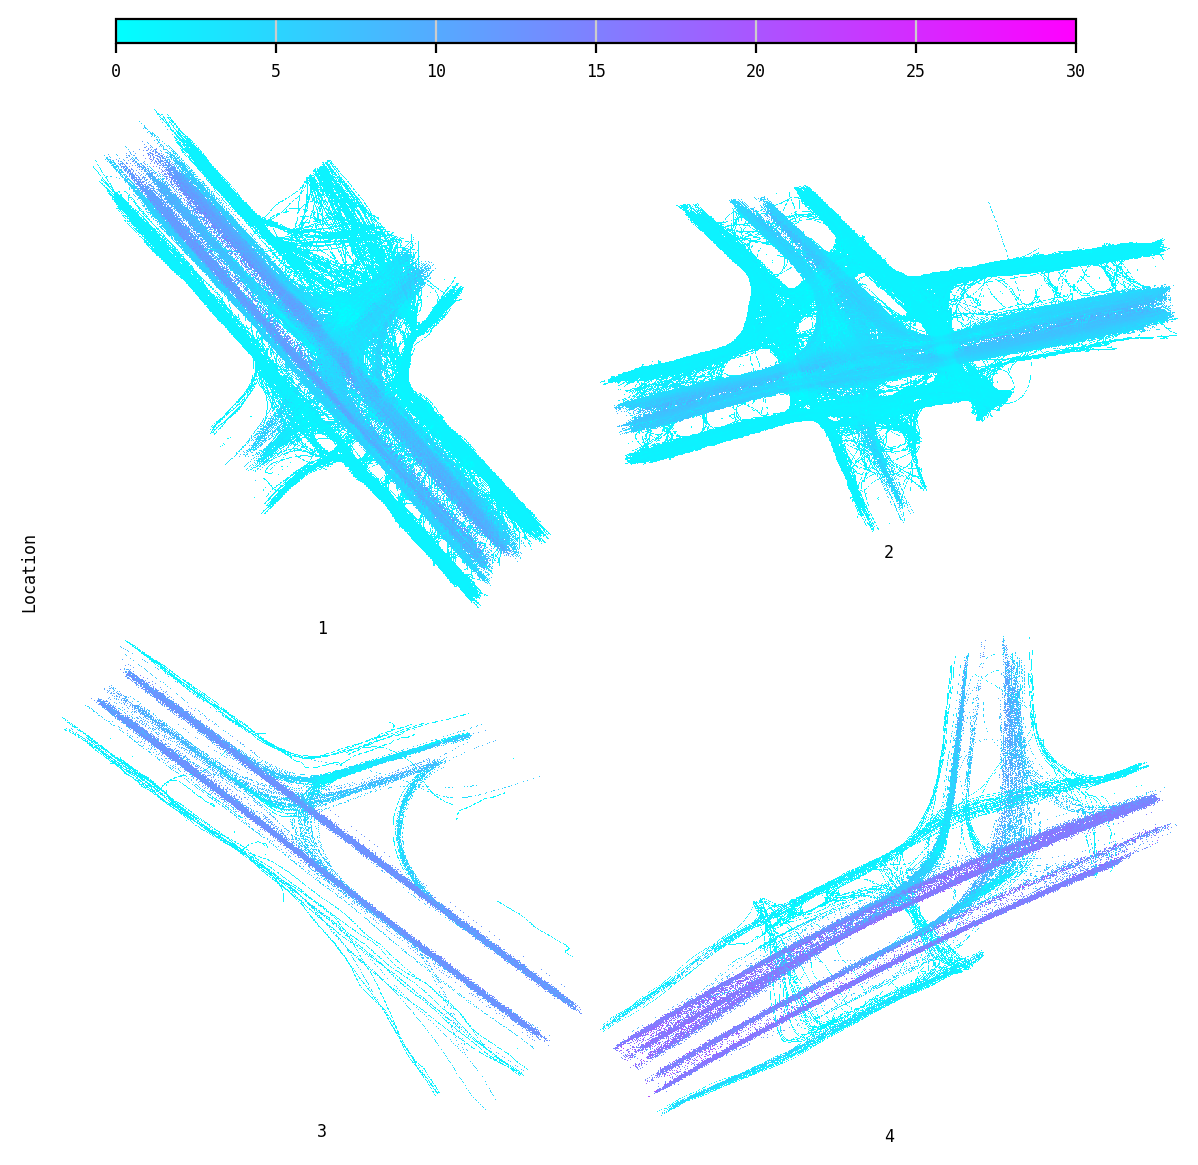

In [9]:
grids = []

fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(2, 2, figure=fig, width_ratios=[0.9, 1])

axes = []
for i in range(4):
    row, col = divmod(i, 2)
    ax = fig.add_subplot(gs[row, col])
    df = (
        dfs[i]
        .group_by(["y_bin", "x_bin"])
        .agg(pl.col("speed (m/s)").mean().alias("avg_speed"))
        .to_pandas()
    )
    grid = df.pivot(index="y_bin", columns="x_bin", values="avg_speed")
    sns.heatmap(
        grid,
        ax=ax,
        cmap="cool",
        cbar=False,
        xticklabels=False,
        yticklabels=False,
        vmin=0,
        vmax=30,
        square=True,
    )
    ax.set_aspect("equal")
    ax.set_xlabel(f"{i+1}")
    ax.set_ylabel("")
    axes.append(ax)

cbar_ax = fig.add_axes([0.1, 0.94, 0.8, 0.02])
fig.colorbar(axes[-1].collections[0], cax=cbar_ax, orientation="horizontal")
fig.text(0.02, 0.5, "Location", va="center", rotation="vertical")

fig.tight_layout(rect=[0.04, 0.02, 1, 0.9])
plt.show()

### Distribution of Speed by Trajectory Type

We visualize the speed distributions of different trajectory types across locations. Due to a large number of frames where car and truck_bus trajectories remain at 0 m/s, a pronounced peak appears near zero. To improve readability, we apply a logarithmic scale to the probability density. The resulting plots show that, in intersection traffic scenarios, the speeds of traffic participants are relatively evenly distributed across their respective feasible ranges.

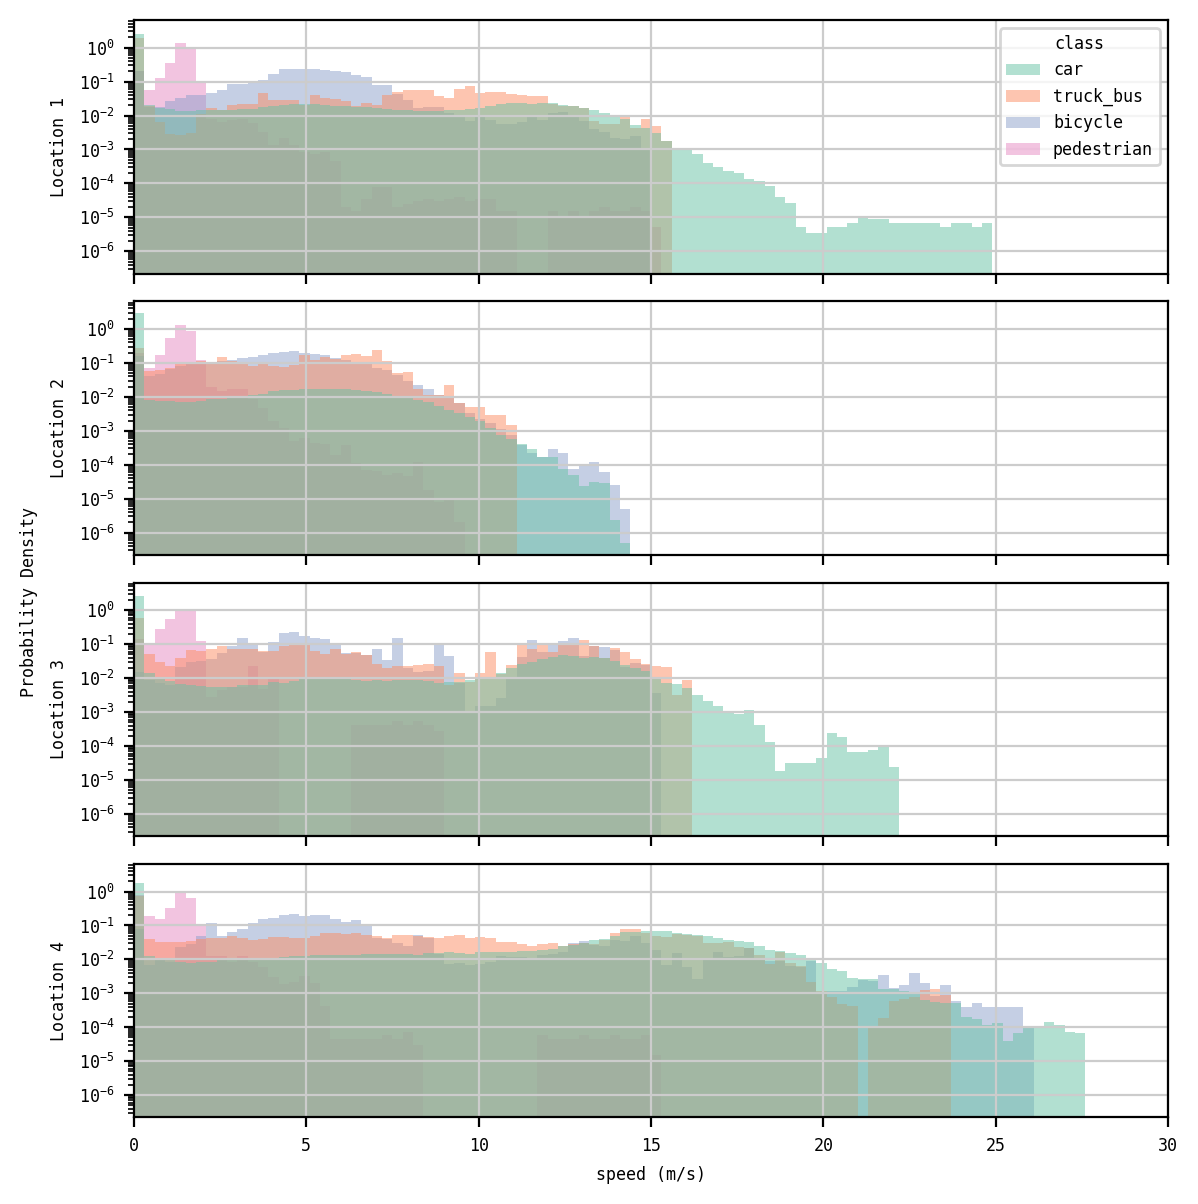

In [10]:
fig, axes = plt.subplots(4, 1, figsize=(6, 6), sharex=True, sharey=True)
for i in range(4):
    df_speed = dfs[i].to_pandas()

    sns.histplot(
        df_speed,
        x="speed (m/s)",
        hue="class",
        hue_order=["car", "truck_bus", "bicycle", "pedestrian"],
        multiple="layer",
        palette="Set2",
        ax=axes[i],
        stat="density",
        common_norm=False,
        log_scale=(False, True),
        binwidth=0.3,
        binrange=(0, 30),
        linewidth=0,
        alpha=0.5,
        legend=(i == 0),
    )

    axes[i].set_xlim([0, 30])
    axes[i].set_ylabel(f"Location {i+1}")
    axes[i].set_yscale("log")

fig.text(0.02, 0.5, "Probability Density", va="center", rotation="vertical")

fig.tight_layout(rect=[0.03, 0, 1, 1])
plt.show()

## Tactics2D Integration

This section explains how to parse and replay logs from the inD dataset by Tactics2D.

### Dataset Preparation

You can place the inD dataset in any directory of your choice. However, it’s important to maintain the following folder structure for compatibility:

```shell
inD
├── data
│   ├── 01_highway.png
│   ├── 01_recordingMeta.csv
│   ├── 01_tracks.csv
│   ├── 01_tracksMeta.csv
│   ├── ...
```

### Class Mapping

The table below illustrates how classes from the inD dataset are mapped to corresponding traffic participants in the Tactics2D framework. 

| inD | Tactics2D |
| --- | --- |
| car | `tactics2d.participant.element.Vehicle` |
| truck_bus | `tactics2d.participant.element.Vehicle` |
| bicycle | `tactics2d.participant.element.Cyclist`|
| pedestrian | `tactics2d.participant.element.Pedestrian` |

### Parse and Replay Logs

To parse, replay, and visualize the inD dataset using Tactics2D, you can use the following code snippet:

In [11]:
%matplotlib notebook

import os
import numpy as np
from matplotlib.animation import FuncAnimation
from shapely.geometry import Point
from IPython.display import HTML

from tactics2d.dataset_parser import LevelXParser
from tactics2d.map.parser import OSMParser
from tactics2d.map.map_config import IND_MAP_CONFIG
from tactics2d.sensor import BEVCamera
from tactics2d.renderer import MatplotlibRenderer

2025-06-26 18:43:28.841321: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Specify the path to the dataset and the map, and then run the following code:

In [12]:
path_dataset = "../../data/inD/data"  # Replace with your dataset path
path_maps = "../../data/inD_map"  # Replace with your map path
dataset_parser = LevelXParser("inD")
map_parser = OSMParser(lanelet2=True)

For simplicity, we revise a function from the `ScenarioManager` to handle the parsing and replaying of the inD dataset:

In [13]:
def render_levelx(map_, participants, map_boundary, stamp_range, resolution):
    x_min, x_max, y_min, y_max = map_boundary
    x_max -= 100
    camera_position = np.array([(x_max + x_min) / 2, (y_max + y_min) / 2])
    camera = BEVCamera(id_=0, map_=map_)

    renderer = MatplotlibRenderer(xlim=(x_min, x_max), ylim=(y_min, y_max), resolution=resolution)

    fig = renderer.fig  # Use the one already created
    frame_list = list(range(stamp_range[0], stamp_range[1], 40))
    prev_road_id_set = set()
    prev_participant_id_set = set()

    def update(frame):
        nonlocal prev_road_id_set, prev_participant_id_set

        participant_ids = [pid for pid, p in participants.items() if p.is_active(frame)]

        geometry_data, prev_road_id_set, prev_participant_id_set = camera.update(
            frame,
            participants,
            participant_ids,
            prev_road_id_set,
            prev_participant_id_set,
            Point(camera_position),
        )

        renderer.update(geometry_data, camera_position)
        renderer.ax.set_title(f"Frame: {frame}")

    ani = FuncAnimation(fig, update, frames=frame_list, interval=40, repeat=True)
    return ani

In [14]:
participants, actual_stamp_range = dataset_parser.parse_trajectory(
    file=7, folder=path_dataset, stamp_range=(0, 10000)
)
map_ = map_parser.parse(
    file_path=os.path.join(path_maps, "inD_1.osm"), configs=IND_MAP_CONFIG["inD_1"]
)

print(f"Map boundary of InD location 1: {map_.boundary}.")

boundary = (-10, 160, -50, 20)
print(f"Map range we display: {boundary}")

ani = render_levelx(map_, participants, boundary, actual_stamp_range, resolution=(2000, 1000))
HTML(ani.to_html5_video())

Map boundary of InD location 1: (-76.0, 149.0, -140.0, 110.0).
Map range we display: (-10, 160, -50, 20)


<IPython.core.display.Javascript object>

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 2000x2000 -pix_fmt rgba -framerate 25.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpx4b31bnx/temp.m4v


In the same way, we display the log in other locations in inD.

In [15]:
participants, actual_stamp_range = dataset_parser.parse_trajectory(
    file=18, folder=path_dataset, stamp_range=(10000, 20000)
)
map_ = map_parser.parse(
    file_path=os.path.join(path_maps, "inD_2.osm"), configs=IND_MAP_CONFIG["inD_2"]
)

print(f"Map boundary of InD location 2: {map_.boundary}.")

boundary = (-40, 190, -50, 20)
print(f"Map range we display: {boundary}")

ani = render_levelx(map_, participants, boundary, actual_stamp_range, resolution=(2000, 1000))
HTML(ani.to_html5_video())

Map boundary of InD location 2: (-148.0, 266.0, -122.0, 71.0).
Map range we display: (-40, 190, -50, 20)


<IPython.core.display.Javascript object>

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:figure size in inches has been adjusted from 10.0 x 5.384615384615384 to 10.0 x 5.38
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 2000x1076 -pix_fmt rgba -framerate 25.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpbyhfhe0u/temp.m4v


In [16]:
participants, actual_stamp_range = dataset_parser.parse_trajectory(
    file=30, folder=path_dataset, stamp_range=(30000, 40000)
)
map_ = map_parser.parse(
    file_path=os.path.join(path_maps, "inD_3.osm"), configs=IND_MAP_CONFIG["inD_3"]
)

print(f"Map boundary of InD location 3: {map_.boundary}.")

boundary = (-30, 170, -50, 20)
print(f"Map range we display: {boundary}")

ani = render_levelx(map_, participants, boundary, actual_stamp_range, resolution=(2000, 1000))
HTML(ani.to_html5_video())

Map boundary of InD location 3: (-54.0, 155.0, -118.0, 40.0).
Map range we display: (-30, 170, -50, 20)


<IPython.core.display.Javascript object>

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 2000x1400 -pix_fmt rgba -framerate 25.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpallyw6e6/temp.m4v


In [17]:
participants, actual_stamp_range = dataset_parser.parse_trajectory(
    file=0, folder=path_dataset, stamp_range=(20000, 30000)
)
map_ = map_parser.parse(
    file_path=os.path.join(path_maps, "inD_4.osm"), configs=IND_MAP_CONFIG["inD_4"]
)

print(f"Map boundary of InD location 4: {map_.boundary}.")

boundary = (-30, 250, -90, 40)
print(f"Map range we display: {boundary}")

ani = render_levelx(map_, participants, boundary, actual_stamp_range, resolution=(2000, 1000))
HTML(ani.to_html5_video())

Map boundary of InD location 4: (-36.0, 377.0, -175.0, 165.0).
Map range we display: (-30, 250, -90, 40)


<IPython.core.display.Javascript object>

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:figure size in inches has been adjusted from 10.0 x 7.222222222222222 to 10.0 x 7.22
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 2000x1444 -pix_fmt rgba -framerate 25.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpmu1ewbnq/temp.m4v


## Appendix: Data Format

<div class="admonition note">
    <p class="admonition-title">Note</p>
    <p>
        This is a backup copy of 
        <a href="https://levelxdata.com/wp-content/uploads/2023/10/inD-Format.pdf" target="_blank" rel="noopener noreferrer">
            the official documentation
        </a>, provided here for reference purposes only.
    </p>
</div>

The inD dataset includes data extracted from 33 recordings. In total four files are provided for each recording:

- An image of the recorded road section (XX_background.png)
- A csv file describing the recording location (XX_recordingsMeta.csv)
- A csv file containing an overview of recorded vehicle and VRU tracks (XX_tracksMeta.csv)
- A csv file for the tracks' trajectories (XX_tracks.csv)
These files are created for each recording to ensure easy handling of the data. In the following, the dataset format
and especially the meaning of every column is explained in detail.

In addition to these four files per recording, Lanelet2 maps for the 4 recording locations are also provided.

### Image of the Road Section

For each recording an georeferenced image of the road section is added. The image was created from the used recording itself by removing all moving vehicles through a filter. Additionally the resolution of the image was reduced.

### Recording Meta Information

This file contains metadata for each recording. The metadata provides a general overview, e.g. of the time of recording, the road section considered and the total number of objects tracked.

| Name | Description | Unit |
| --- | --- | --- |
| recordingId | The ID of the recording. Every recording has a unique ID. | [-] |
| locationId | The ID of the recording location. | [-] |
| frameRate | The frame rate which was used to record the video. | [Hz] |
| speedLimit | The speed limit of the driving lanes. | [m/s] |
| weekday | The weekday the recording was done. | [-] |
| startTime | The hour at which the recording was started. | [hh] |
| duration | The duration of the recording. | [s] |
| numTracks | The number of objects tracked. | [-] |
| numVehicles | The number of vehicles tracked. | [-] |
| numVRUs | The number of vulnerable road users (VRUs) tracked. | [-] |
| latLocation | Rough latitude coordinates of recording location. **Not the same point as the UTM coordinates below!** | [deg] |
| lonLocation | Rough longitude coordinates of recording location. **Not the same point as the UTM coordinates below!** | [deg] |
| xUtmOrigin | X value of UTM coordinate of origin of the local coordinate system for this recording location. Add this to xCenter to get UTM coordinates. See below for more information on the coordinate system. | [m] |
| yUtmOrigin | Y value of UTM coordinate of origin of the local coordinate system for this recording location. Add this to yCenter to get UTM coordinates. See below for more information on the coordinate system. | [m] |
| orthoPxToMeter | Scale factor from ortho image pixels to UTM meters. This value is needed for visualization. | [m/px] |

### Track Meta Information

This file contains an overview of all tracks. The purpose of this file is to allow to filter tracks e.g. by class.

| Name | Description | Unit |
| --- | --- | --- |
| recordingId | The ID of the recording. Every recording has a unique ID. | [-] |
| trackId | The ID of the track. The IDs are assigned in ascending order for each recording. | [-] |
| initialFrame | The frame in which the track starts. | [-] |
| finalFrame | The frame in which the track ends. | [-] |
| numFrames | The total lifetime in frames. | [-] |
| width | The width of the tracked object. This property is set to zero for VRUs. | [m] |
| length | The length of the tracked object. This property is set to zero for VRUs. | [m] |
| class | The class of the tracked object. | [-] |

### Tracks

This file contains all time dependent values for each track. Information such as current position, velocity and acceleration.

| Name | Description | Unit |
| --- | --- | --- |
| recordingId | The ID of the recording. Every recording has a unique ID. | [-] |
| trackId | The ID of the track. The IDs are assigned in ascending order for each recording. | [-] |
| frame | The frame for which the information are given. | [-] |
| trackLifetime | The current age of the track at this frame. | [-] |
| xCenter | The x position of the object's centroid in the local coordinate system. Add xUtmOrigin to get UTM coordinates. | [m] |
| yCenter | The y position of the object's centroid in the local coordinate system. Add yUtmOrigin to get UTM coordinates. | [m] |
| heading | The heading in the local coordinate system. | [deg] |
| width | The width of the tracked object (0 for VRUs). | [m] |
| length | The length of the tracked object (0 for VRUs). | [m] |
| xVelocity | The velocity in x-axis direction in the local coordinate system. | [m/s] |
| yVelocity | The velocity in y-axis direction in the local coordinate system. | [m/s] |
| xAcceleration | The acceleration in x-axis direction in the local coordinate system. | [m/s²] |
| yAcceleration | The acceleration in y-axis direction in the local coordinate system. | [m/s²] |
| lonVelocity | The longitudinal velocity. | [m/s] |
| latVelocity | The lateral velocity. | [m/s] |
| lonAcceleration | The longitudinal acceleration. | [m/s²] |
| latAcceleration | The lateral acceleration. | [m/s²] |

### Coordinate System

The global coordinate system used is the UTM coordinate system, as we geo-referenced our data. For easier handling of data of the same intersection in different recordings, we introduced a local UTM-like coordinate system. The only difference is, that the origin (0, 0) is very close to the recorded road section and the same for all recordings at each location. To transform positions into the global UTM coordinate system, just add xUtmOrigin and yUtmOrigin to all positions. The local coordinate system looks as follows: The horizontal axis is the x-axis, which grows to the right. The vertical axis is the y-axis, which grows upwards. The heading is calcuated as in the UTM coordinate system. Finally, we use SI units only.

![The coordinate system of inD dataset](https://raw.githubusercontent.com/MotacillaAlba/image-storage/main/img/inD-coordinate-system.png)